In [1]:
import pmssm

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
Path("plots/").mkdir(parents=True, exist_ok=True)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

print("Set device to:", device)

Running in Jupyter
Set device to: cuda


Found 300 ROOT files
Only using 3 out of the 300 datasets!!


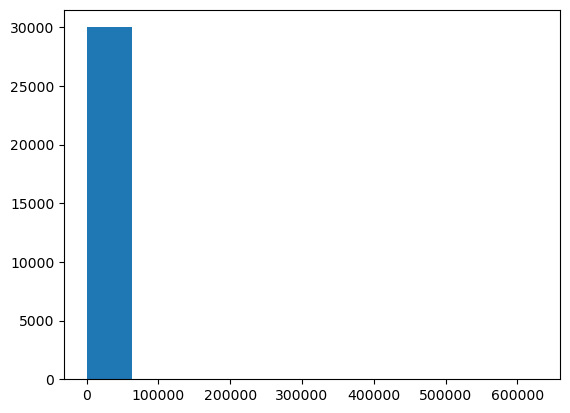

Have n_train=21051, n_val=2339


In [2]:
# Load once
X, Y = pmssm.load_pmssm_data(n_datasets=3)

# Split once
idx_train, idx_val = pmssm.make_split(X)

# Stats from training only
stats = pmssm.compute_stats(X, Y, idx_train)

# Datasets
train_dataset = pmssm.PMSSMDataset(X, Y, idx_train, stats, n_samples=30)
val_dataset   = pmssm.PMSSMDataset(X, Y, idx_val, stats, n_samples=30)

train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=256, shuffle=False
)

In [3]:
# Train transformer:
model = pmssm.PMSSMTransformer(
    d_model=16,
    nhead=1,
    num_layers=2,
    dim_feedforward=64,
)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.MSELoss()

train_losses, val_losses = pmssm.train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device=device,
    epochs=5_000,
    early_stopping=False
)

/scratch/users/jwuerzin/pMSSM/pMSSM-trafo/.pixi/envs/default/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 000 | Train MSE = 0.323565 | Val MSE = 1.546524
Epoch 001 | Train MSE = 0.307471 | Val MSE = 1.553179
Epoch 002 | Train MSE = 0.296209 | Val MSE = 1.560249
Epoch 003 | Train MSE = 0.234326 | Val MSE = 1.567707
Epoch 004 | Train MSE = 0.250287 | Val MSE = 1.575514
Epoch 005 | Train MSE = 0.230869 | Val MSE = 1.583758
Epoch 006 | Train MSE = 0.231842 | Val MSE = 1.592401
Epoch 007 | Train MSE = 0.235350 | Val MSE = 1.601466
Epoch 008 | Train MSE = 0.221608 | Val MSE = 1.610711
Epoch 009 | Train MSE = 0.220867 | Val MSE = 1.620234
Epoch 010 | Train MSE = 0.225119 | Val MSE = 1.629993
Epoch 011 | Train MSE = 0.177770 | Val MSE = 1.640058
Epoch 012 | Train MSE = 0.174290 | Val MSE = 1.650284
Epoch 013 | Train MSE = 0.195075 | Val MSE = 1.660654
Epoch 014 | Train MSE = 0.158861 | Val MSE = 1.671202
Epoch 015 | Train MSE = 0.189953 | Val MSE = 1.681912
Epoch 016 | Train MSE = 0.154115 | Val MSE = 1.692619
Epoch 017 | Train MSE = 0.177318 | Val MSE = 1.703369
Epoch 018 | Train MSE = 0.14

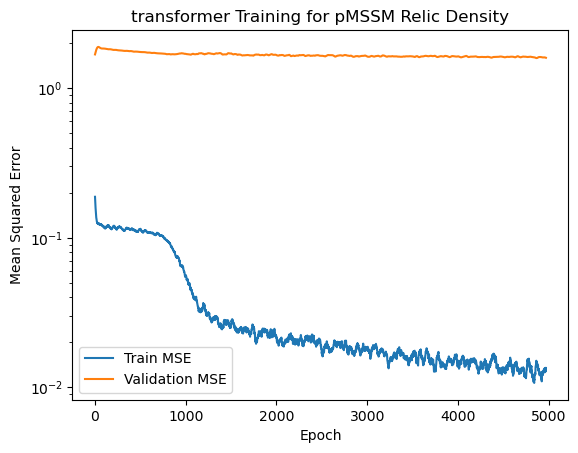

In [4]:
pmssm.plot_losses(train_losses, val_losses, model)

# Compare random points

In [5]:
# compare training points
pmssm.compare_random_predictions(
    model,
    stats=stats,
    subset=train_dataset,
    mode='train',
    device=device,
    n_points=10,
)


Comparison on random training points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
    12 |            -0.303782 |               -0.361144 |     0.033000 |        0.025727
    17 |            -0.490947 |               -0.552690 |     0.009270 |        0.001442
     8 |            -0.484400 |               -0.430590 |     0.010100 |        0.016922
    13 |            -0.050601 |               -0.095255 |     0.065100 |        0.059438
    23 |            -0.183896 |               -0.275679 |     0.048200 |        0.036563
     6 |            -0.485504 |               -0.521996 |     0.009960 |        0.005333
    11 |            -0.127896 |               -0.269042 |     0.055300 |        0.037405
     2 |             0.398184 |                0.350421 |     0.122

In [6]:
# compare validation points:
pmssm.compare_random_predictions(
    model,
    stats=stats,
    subset=val_dataset,
    mode='validation',
    device=device,
    n_points=3,
)


Comparison on random validation points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
    29 |            -0.539138 |               -0.523180 |     0.003160 |        0.005183
    12 |            -0.323500 |               -0.296539 |     0.030500 |        0.033918
     4 |            -0.557965 |               -0.566934 |     0.000773 |       -0.000364
------------------------------------------------------------------------------------------


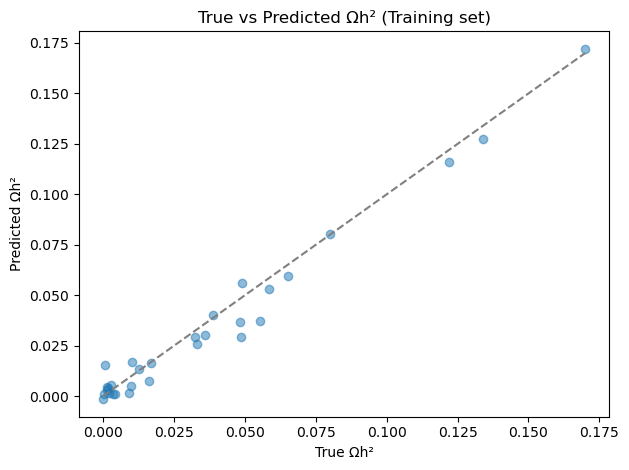

In [7]:
pmssm.scatter_true_vs_pred(
    model,
    stats=stats,
    subset=train_dataset,
    mode='train',
    device=device
)

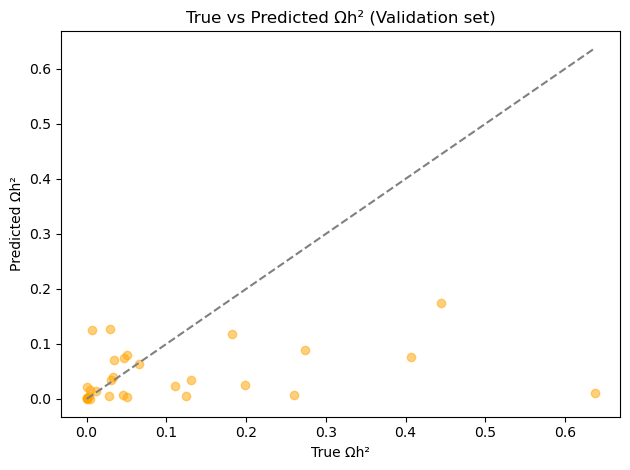

In [8]:
pmssm.scatter_true_vs_pred(
    model,
    stats=stats,
    subset=val_dataset,
    mode='validation',
    device=device
)

# Train MLP

In [9]:
# train MLP
model = pmssm.PMSSMFeedForward(
    d_model = 64,
    num_layers = 4,
    dim_feedforward = 256*2,
)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.MSELoss()

train_losses, val_losses = pmssm.train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device=device,
    epochs=2_000,
    early_stopping=False
)

Epoch 000 | Train MSE = 0.229170 | Val MSE = 1.530282
Epoch 001 | Train MSE = 0.201748 | Val MSE = 1.551979
Epoch 002 | Train MSE = 0.179283 | Val MSE = 1.576776
Epoch 003 | Train MSE = 0.159428 | Val MSE = 1.607170
Epoch 004 | Train MSE = 0.141577 | Val MSE = 1.644966
Epoch 005 | Train MSE = 0.126445 | Val MSE = 1.692329
Epoch 006 | Train MSE = 0.115211 | Val MSE = 1.749695
Epoch 007 | Train MSE = 0.109047 | Val MSE = 1.813059
Epoch 008 | Train MSE = 0.108877 | Val MSE = 1.868523
Epoch 009 | Train MSE = 0.112667 | Val MSE = 1.898223
Epoch 010 | Train MSE = 0.115072 | Val MSE = 1.898557
Epoch 011 | Train MSE = 0.113239 | Val MSE = 1.877469
Epoch 012 | Train MSE = 0.108409 | Val MSE = 1.845071
Epoch 013 | Train MSE = 0.103196 | Val MSE = 1.809837
Epoch 014 | Train MSE = 0.099441 | Val MSE = 1.778087
Epoch 015 | Train MSE = 0.097478 | Val MSE = 1.753301
Epoch 016 | Train MSE = 0.096827 | Val MSE = 1.736597
Epoch 017 | Train MSE = 0.096535 | Val MSE = 1.728109
Epoch 018 | Train MSE = 0.09

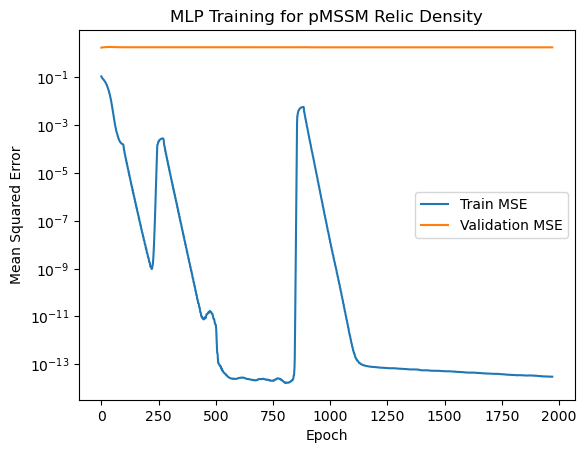

In [10]:
pmssm.plot_losses(train_losses, val_losses, model)

In [11]:
# compare training points
pmssm.compare_random_predictions(
    model,
    stats=stats,
    subset=train_dataset,
    mode='train',
    device=device,
    n_points=10,
)


Comparison on random training points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
    19 |            -0.536535 |               -0.536535 |     0.003490 |        0.003490
     6 |            -0.485504 |               -0.485504 |     0.009960 |        0.009960
    20 |            -0.430767 |               -0.430767 |     0.016900 |        0.016900
    22 |            -0.562003 |               -0.562003 |     0.000261 |        0.000261
     1 |            -0.563210 |               -0.563209 |     0.000108 |        0.000108
    27 |             0.776773 |                0.776773 |     0.170000 |        0.170000
    24 |            -0.559613 |               -0.559612 |     0.000564 |        0.000564
    28 |            -0.529358 |               -0.529358 |     0.004

In [12]:
# compare validation points:
pmssm.compare_random_predictions(
    model,
    stats=stats,
    subset=val_dataset,
    mode='validation',
    device=device,
    n_points=3,
)


Comparison on random validation points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
    24 |            -0.328232 |               -0.307795 |     0.029900 |        0.032491
     7 |             1.597048 |               -0.243643 |     0.274000 |        0.040625
    12 |            -0.323500 |               -0.632573 |     0.030500 |       -0.008686
------------------------------------------------------------------------------------------


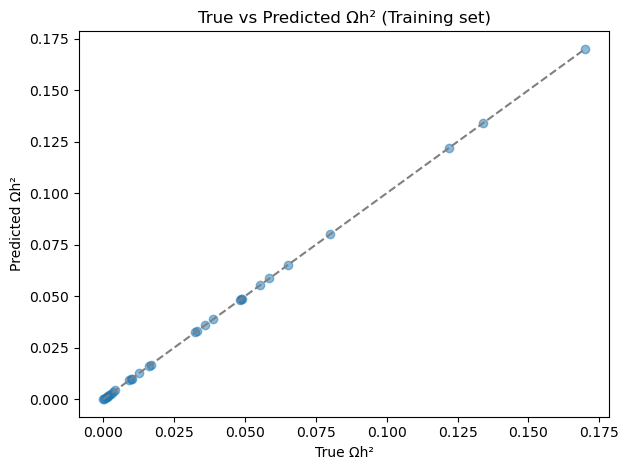

In [13]:
pmssm.scatter_true_vs_pred(
    model,
    stats=stats,
    subset=train_dataset,
    mode='train',
    device=device
)

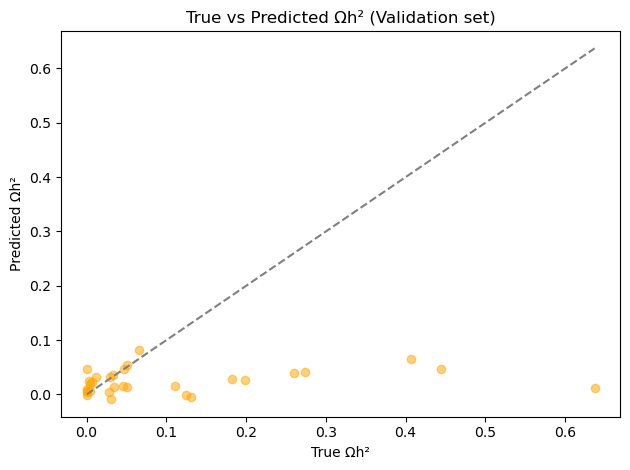

In [14]:
pmssm.scatter_true_vs_pred(
    model,
    stats=stats,
    subset=val_dataset,
    mode='validation',
    device=device
)